In [1]:
! pip install ..
%load_ext autoreload
%autoreload 2

Processing /Users/amiyaguchi/Research/wiki-forecast
  Created wheel for wiki-forecast: filename=wiki_forecast-0.3.2-cp36-none-any.whl size=18046 sha256=909581df7aa4a108c4247a4c9655754c47c210b72f14cebe969c86f646a5ae31
  Stored in directory: /Users/amiyaguchi/Library/Caches/pip/wheels/4f/a1/40/0ace60fd57f0bb1ff87e264f714aa5255c9d115906476a9f13
Successfully built wiki-forecast
  Found existing installation: wiki-forecast 0.3.2
    Uninstalling wiki-forecast-0.3.2:
      Successfully uninstalled wiki-forecast-0.3.2
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pyspark.sql import SparkSession, functions as F, Window
from graphframes import GraphFrame
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from wikicast.bipartition import (
    induce_graph, 
    undo_relabel, 
    edges_with_partitions,
    sparse_matrix_from_edgelist
)

spark = SparkSession.builder.getOrCreate()
pages = spark.read.parquet("../data/clustered/sample_1_8_50")
pagelinks = spark.read.parquet("../data/enwiki/pagelinks")

pages.printSchema()
pagelinks.printSchema()

graph = induce_graph(
    GraphFrame(pages, pagelinks.selectExpr("from as src", "dest as dst")),
    relabel=False
)
graph.cache()

print(f"graph has {graph.vertices.count()} articles and {graph.edges.count()} hyperlinks")

graph.vertices.show(vertical=True, n=1)

root
 |-- id: integer (nullable = true)
 |-- bias: boolean (nullable = true)
 |-- sign_0: boolean (nullable = true)
 |-- sign_1: boolean (nullable = true)
 |-- sign_2: boolean (nullable = true)
 |-- sign_3: boolean (nullable = true)
 |-- sign_4: boolean (nullable = true)
 |-- sign_5: boolean (nullable = true)
 |-- sign_6: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- is_redirect: boolean (nullable = true)
 |-- is_new: boolean (nullable = true)
 |-- fiedler_0: double (nullable = true)
 |-- fiedler_1: double (nullable = true)
 |-- fiedler_2: double (nullable = true)
 |-- fiedler_3: double (nullable = true)
 |-- fiedler_4: double (nullable = true)
 |-- fiedler_5: double (nullable = true)
 |-- fiedler_6: double (nullable = true)
 |-- fiedler_7: double (nullable = true)
 |-- sign_7: boolean (nullable = true)

root
 |-- from: integer (nullable = true)
 |-- dest: integer (nullable = true)

graph has 2936436 articles and 52893186 hyperlinks
-RECORD 0----------------------

+------+-----+
|degree|count|
+------+-----+
|     1|19857|
|     2|13736|
|     3|10733|
|     4| 9400|
|     5| 8211|
+------+-----+
only showing top 5 rows



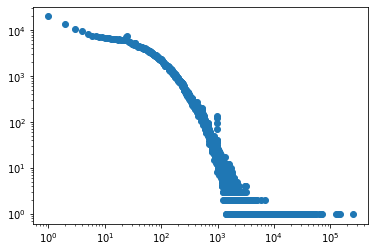

In [3]:
graph.degrees.cache()
degree = graph.degrees.groupBy("degree").count().orderBy(F.desc("count"))
degree.show(n=5)

df = degree.toPandas()
plt.scatter(df["degree"], df["count"])
plt.xscale("log")
plt.yscale("log")

+-------+----+--------------------+------+------------+
|     id|sign|               title|degree|relabeled_id|
+-------+----+--------------------+------+------------+
|2936428|ooxo| Julie_Kumari_Mahato|    11|     2936428|
| 496028|xoox|             Tétange| 18638|      496028|
|  57070|ooox|    Harvey_Fierstein| 38171|       57070|
|1339871|xxxo|Gary_Williams_(fo...|136937|     1339871|
|  51509|xxox|List_of_Uniform_A...| 38793|       51509|
| 422994|ooxx|Odyssey_(Hayley_W...| 72652|      422994|
|2059097|oooo|     ASSIA_(company)| 54754|     2059097|
|2936433|xxoo|    Annette_Jörnlind|   186|     2936433|
|  11113|ooxo|List_of_business_...| 32403|       11113|
|  14919|oxoo|           Biproduct|249547|       14919|
|  32927|oxxo|Brownington,_Miss...| 44361|       32927|
|  68253|xxxx|Crimen_sollicitat...| 49492|       68253|
|2936404|oxoo|   Summer_at_Carcoar|   312|     2936404|
|  31717|xoxo|Brooklyn_Park,_Mi...| 48174|       31717|
| 432383|xoxx|County_Route_569_...| 32518|      

/Users/amiyaguchi/.local/share/virtualenvs/wiki-forecast-HU65IRGn/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


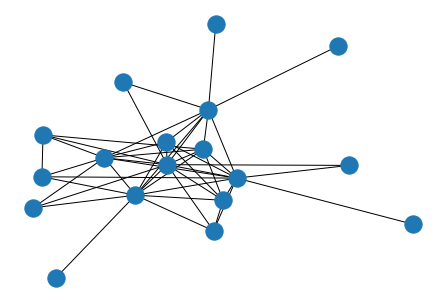

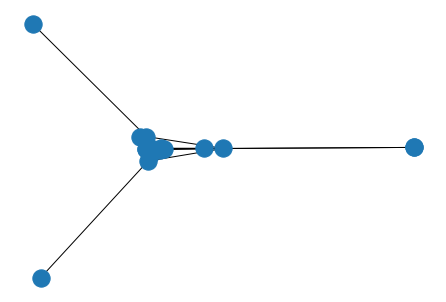

In [4]:
def sign_to_string(*signs):
    result = ""
    for sign in signs:
        result += "x" if sign else "o"
    return result

s2s = F.udf(sign_to_string, "string")

def sign_range(k):
    return [f"sign_{i}" for i in range(k)]

signs = sign_range(4)

query = (
    graph.vertices
    .join(graph.degrees, on="id", how="left")
    .where("degree is not null")
    .withColumn("rank", F.row_number().over(Window.partitionBy(*signs).orderBy(F.desc("degree"))))
    .orderBy(*signs + ["degree"])
    .select("id", s2s(*signs).alias("sign"), "title", "degree")
)

clusters = induce_graph(
    GraphFrame(query.where("rank <= 1"), graph.edges), relabel=False
)
clusters.cache()
clusters.vertices.show()

nodes = clusters.vertices.toPandas()
labels = {nid: title for nid, title in zip(nodes.id, nodes.title)}

g = nx.from_pandas_edgelist(
    clusters.edges.toPandas(), 
    source="src", 
    target="dst",
    create_using=nx.Graph
)

gc = max(nx.connected_component_subgraphs(g), key=len)

nx.draw(gc)
plt.show()

pos=nx.drawing.spectral_layout(gc)
nx.draw(gc, pos)
plt.show()

## Compute pagerank efficiently

We can remove the cross cluster hyperlinks, and compute pagerank on these disconnected clusters. This will be useful for local ranking.

In [ ]:
# we can remove the inter
parted = induce_graph(
    GraphFrame(graph.vertices.withColumn("sign", s2s(*sign_range(8))), graph.edges),
    relabel=True,
    partitions=signs + ["sign"]
)
parted.cache()
print(parted.edges.count())

In [34]:
n = 8

num_edges = []
for i in range(n):
    res = edges_with_partitions(parted, partitions=sign_range(n)[:i+1]).count()
    print(res)
    num_edges.append(res)

27360469
13753958
6941592
3494980
1754069
879154
441040
220756


The number of edges is a lot easier to work with and should take orders of magnitude less time to run things like pagerank locally, due to the up-front cost of partitioning,

In [35]:
trimmed = GraphFrame(parted.vertices, edges_with_partitions(parted, partitions=sign_range(8)))
ranked = trimmed.pageRank(resetProbability=0.15, maxIter=10)

ranked.cache()

GraphFrame(v:[id: int, bias: boolean ... 22 more fields], e:[src: int, dst: int ... 9 more fields])

In [36]:
top_k = (
    ranked.vertices
    .withColumn("rank", 
                F.row_number().over(Window.partitionBy(*signs).orderBy(F.desc("pagerank"))))
    .where("rank <= 15")
    .orderBy("sign", F.desc("pagerank"))
    .select(F.col("relabeled_id").alias("id"), "sign", "title", "pagerank")
)
top_k.show()
G = induce_graph(GraphFrame(top_k, graph.edges))
G.cache()

nodes = G.vertices.toPandas()
labels = {nid: title for nid, title in zip(nodes.id, nodes.title)}

colors = {c:v for v,c in enumerate(sorted(set(s[:2] for s in nodes.sign)))}

g = nx.Graph()
for i, node in nodes.iterrows():
    g.add_node(node.id, title=node.title, color=colors[node.sign[:2]], pagerank=node.pagerank)

for i, edge in G.edges.toPandas().iterrows():
    g.add_edge(edge.src, edge.dst)

gc = max(nx.connected_component_subgraphs(g), key=len)
print(len(gc), len(nodes))

+-------+----+--------------------+-------------------+
|     id|sign|               title|           pagerank|
+-------+----+--------------------+-------------------+
|   4414|oooo|Lossless_compression|  371.5850651104498|
|  42905|oooo|John_Oswald_(comp...|  320.8166784313925|
| 502463|oooo|St._Norbert_(disa...|  277.7592957146683|
|1301057|oooo|            Aase_Bye|  262.2518354492863|
|  47548|oooo|Charles_Watson-We...| 251.63222009541695|
| 325175|oooo|   Karafuto_Fortress| 220.31906776838284|
| 163962|oooo|British_Rail_Clas...| 191.38233630036837|
| 737698|oooo|Joseph_Pitty_Cout...| 172.32579869143294|
|  72261|oooo|Willamette_locomo...| 160.08906672844316|
|  45262|oooo|       Melanie_Klein| 155.85916152714782|
| 501256|oooo|Maritime_court_(C...| 138.70757981505992|
|  60872|oooo|          Roy_Ridley| 130.78240712801684|
|   5836|oooo|             Phenols| 118.00464334772805|
|   6657|oooo|  Sub-Saharan_Africa| 117.91971045281858|
| 503286|oooo|      Álvaro_Urquijo| 117.08425641

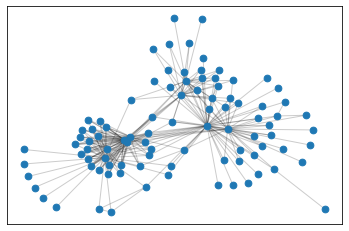

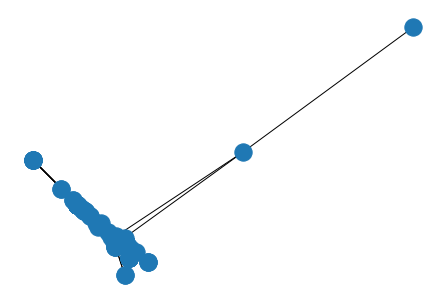

In [37]:
pos = nx.spring_layout(gc)
ec = nx.draw_networkx_edges(gc, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(gc, pos, nodelist=gc.nodes, 
                            #node_color=[c for _, c in gc.nodes("color")], 
                            with_labels=False, node_size=45, cmap="coolwarm")
# plt.colorbar(nc)
plt.show()

pos=nx.drawing.spectral_layout(gc)
nc = nx.draw(gc, pos)
plt.show()

In [38]:
# top_k.drop("pagerank").union(query.where("rank <= 3").drop("degree"))

# TODO

* compute laplacian per group
* (maybe) compute truncated svd per group
* vectorize the time series, sign, fiedler, hub, pagerank, laplacian
* compute linear regression on only embeddings
* feed neural network in keras


In [5]:
from wikicast.bipartition import (
    induce_graph, 
    undo_relabel, 
    edges_with_partitions,
    sparse_matrix_from_edgelist
)

parted = induce_graph(
    GraphFrame(
        graph.vertices.withColumn("sign", s2s(*sign_range(8))).where("sign like 'oooo%'"), 
        graph.edges
    ),
    relabel=True
)
parted.cache()
parted.vertices.count(), parted.edges.count()

(228116, 388902)

In [58]:
test_g = sparse_matrix_from_edgelist(parted.edges.toPandas())

In [59]:
test_g.shape

(228106, 228106)

In [ ]:
from pyspark.sql.functions import PandasUDFType, pandas_udf
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

def laplacian_eigenmap(g, dim):
    L, D = laplacian(g, return_diag=True)
    _, v = eigsh(L, k=dim+1, M=np.diag(D))
    return w[1:]


emb = laplacian_eigenmap(test_g, 8)

In [9]:
from pathlib import Path
checkpoint_dir = "file:///" + "/".join((Path("..").resolve() / "data/tmp").parts[1:])
spark.sparkContext.setCheckpointDir(checkpoint_dir)
parted.connectedComponents().groupBy("component").count().orderBy(F.desc("count")).withColumn("sum", F.expr("sum(count) over ()")).show()

+---------+-----+------+
|component|count|   sum|
+---------+-----+------+
|       10|50749|228116|
|    67934|   33|228116|
|    63395|   10|228116|
|    66517|    9|228116|
|    63864|    7|228116|
|   131838|    6|228116|
|    91080|    5|228116|
|    77411|    5|228116|
|    61807|    4|228116|
|   186868|    4|228116|
|   142341|    4|228116|
|    93762|    4|228116|
|    77412|    4|228116|
|    16812|    4|228116|
|    92660|    4|228116|
|    79146|    4|228116|
|   107523|    4|228116|
|    74874|    4|228116|
|    80938|    4|228116|
|   139566|    4|228116|
+---------+-----+------+
only showing top 20 rows

